# Machine Learning 2023-2024 - UMONS

# The Bootstrap.

In this lab, we'll experiment with **the bootstrap**, a simple but powerful resampling method that allows to quantify the uncertainty associated with any statistic estimated from a population sample. Additionally, the bootstrap enables us to estimate the validation error of any learning model, similarly to cross-validation. 

The steps of the (non-parametric) boostrap procedure can be summarized as:
- Start with a dataset $\mathcal{D} = \{z_i\}_{i=1}^n$.
- For $b=1,...,B$, do:
  - Sample a dataset $\mathcal{D}^{(b)}=\{z_i^{\ast~(b)}\}_{i=1}^n$ with replacement from the original dataset $\mathcal{D}$.
  - Estimate the statistic of interest on $\hat{\theta}^{\ast~(b)} = s(\mathcal{D}^{(b)})$ (e.g. the mean, $\hat{\theta}^{\ast~(b)} = \frac{1}{n}\sum_{i=1}^n z_i^{\ast~(b)}$).
- Compute the sampling distribution of the statistic $s$ from $\{\hat{\theta}^{\ast~(1)},...,\hat{\theta}^{\ast~(B)}\}$.

The sampling distribution of the statistic $s$ can then be used to quantify the uncertainty associated with $\hat{\theta} = s(\mathcal{D})$, the statistic's estimate from the original dataset $\mathcal{D}$. To get some intuition of the concept, we will start by applying the bootstrap algorithm on some simulated data, whose mean and variance is known.

**We import the necessary libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

np.random.seed(0)

**1) Generate a dataset $\mathcal{D}$ with $n=100$ observations from a Normal distribution with $\mu =6$ and $\sigma=2$. Check the `np.random.normal` function.**

In [2]:
true_mean = 6
true_std = 2
z = np.random.normal(true_mean, true_std, 100) # TODO: z = ...

**Let's take a look at the CDFs of the population distribution and the empirical distribution.**

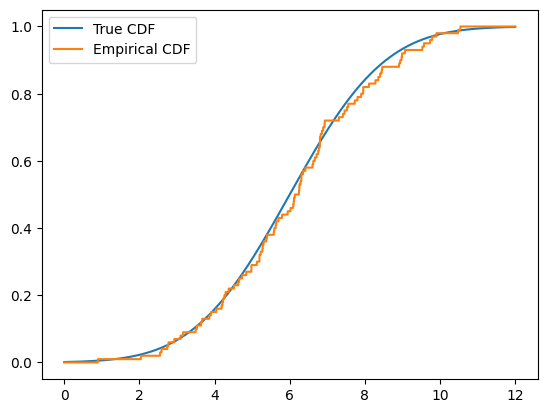

In [3]:
fig, ax = plt.subplots()
z_plot = np.linspace(0, 12, 10000)
ax.plot(z_plot, norm.cdf(z_plot, true_mean, true_std), label='True CDF')
ax.plot(z_plot, np.mean(z <= z_plot[:, np.newaxis], axis=1), label='Empirical CDF')
ax.legend();

**2) Compute the sample mean $\bar{z}$ and sample standard deviation $\bar{\sigma}$ of the dataset $\mathcal{D}$.** 

In [4]:
sample_mean = np.mean(z)
sample_std = np.std(z, ddof=1)

print(f'Estimated mean: {sample_mean:.3f}')
print(f'Estimated Standard Deviation: {sample_std:.3f}')

Estimated mean: 6.120
Estimated Standard Deviation: 2.026


**3) Implement the bootstrap algorithm defined above for $B=1000$. Our goal here is to quantify the uncertainty associated to the sample mean $\bar{z} = \frac{1}{n} \sum_{i=1}^n z_i$ and standard deviation $s = \frac{1}{n - 1} \sum_{i=1}^n (z_i - \bar{z})^2$ using a 90% confidence interval.**

**First, resample $B$ datasets using `sklearn.utils.resample` and collect the sample mean and standard deviation for each dataset.**

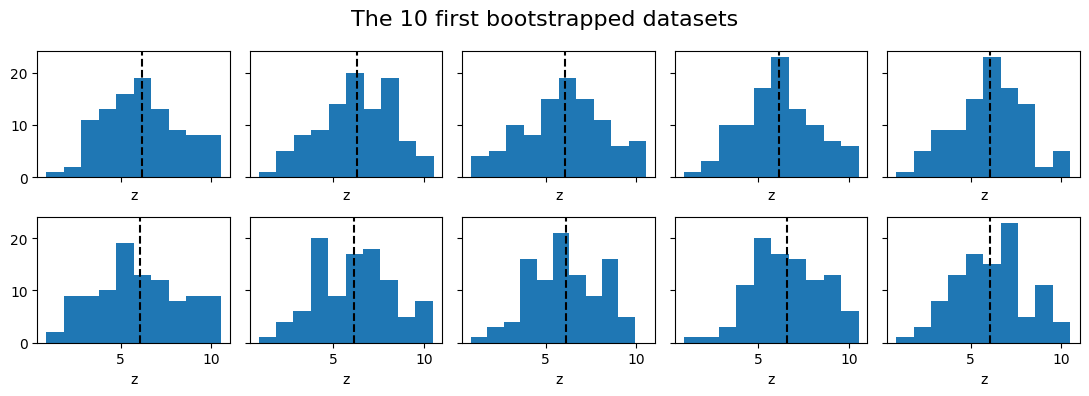

In [5]:
n_resamples = 1000

nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(11, 4))
axes = axes.flatten()

bootstrap_means = []
bootstrap_stds = []
nb_unique = []
for i in range(n_resamples):
    dataset = resample(z, n_samples=len(z), replace=True)
    bootstrap_mean = np.mean(dataset)
    bootstrap_std = np.std(dataset, ddof=1)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_stds.append(bootstrap_std)
    nb_unique.append(len(np.unique(dataset)))
    if i < nrows * ncols: # We plot an example of bootstrap dataset
        axis = axes[i]
        axis.hist(dataset)
        axis.axvline(bootstrap_mean, color='black', ls='--', label='Bootstrap mean')
        axis.set_xlabel('z')
fig.suptitle('The 10 first bootstrapped datasets', fontsize=16)
fig.tight_layout()

**4) What is the average number of unique points per bootstrap sample (i.e., the number of points that have been sampled at least once)? Compute it by modifying the code above. You can use the function `np.unique`.**

**Can you compute the expected number of unique points per bootstrap sample using the theory of the course?**

In [6]:
n = len(z)
probability_of_chosing_a_point = 1 - (1 - 1 / n)**n
print(f'Average number of unique points: {np.mean(nb_unique)} ~= {probability_of_chosing_a_point * n:.3f}')

Average number of unique points: 63.416 ~= 63.397


**5) Let $\hat{z}^{\ast~(b)}$ denote the sample means obtained on each bootstrapped dataset. For a confidence level $1 - \alpha$, a bootstrap empirical confidence interval for $\bar{z}$ can be obtained as:**

$$\text{CI} = [q_{\alpha/2}(\hat{z}^{\ast~(b)}), q_{1-\alpha/2}(\hat{z}^{\ast~(b)})]$$

**where $q_{\alpha}(\hat{z}^{\ast~(b)})$ is the $\alpha$-quantile of the sampling distribution of $\hat{z}^{\ast~(b)}$ (e.g. the median of $\hat{z}^{\ast~(b)}$ is $q_{0.5}(\hat{z}^{\ast~(b)})$).**

**Check the method `np.quantile` to compute quantiles.**

**Then, plot the sampling distribution of the mean (e.g., using `sns.histplot`) and add the true value, the sample estimate and the 90% confidence interval.**

**Redo the same for the sample standard deviation $\hat{\sigma}$.**


Sample estimate: 6.12
Confidence Interval: [5.78, 6.45]
Sample estimate: 2.03
Confidence Interval: [1.79, 2.22]


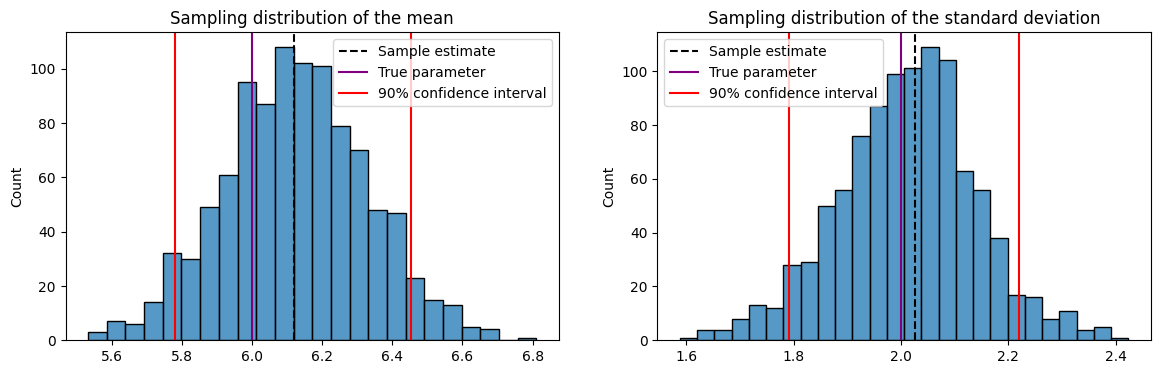

In [7]:
def plot_confidence_interval(sample_estimate, true_parameter, bootstrap_estimates, axis):
    interval = np.quantile(bootstrap_estimates, q=[0.05, 0.95])
    print(f'Sample estimate: {sample_estimate:.2f}')
    print(f'Confidence Interval: [{interval[0]:.2f}, {interval[1]:.2f}]')
    sns.histplot(data=bootstrap_estimates, ax=axis)
    axis.axvline(sample_estimate, color='black', ls='--', label='Sample estimate')
    axis.axvline(true_parameter, color='purple', label='True parameter')
    axis.axvline(interval[0], color='red', label='90% confidence interval')
    axis.axvline(interval[1], color='red')
    axis.legend()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_confidence_interval(sample_mean, true_mean, bootstrap_means, axes[0])
axes[0].set_title('Sampling distribution of the mean')
plot_confidence_interval(sample_std, true_std, bootstrap_stds, axes[1])
axes[1].set_title('Sampling distribution of the standard deviation');

**We will now use bootstrapping to estimate the uncertainty associated to the mean of a sample drawn from an unknown distribution. To this end, we will reuse the 'Fish Market' dataset, and apply the bootstrap to the variable 'Height'.**

In [8]:
df = pd.read_csv('data/fish_lab.csv', index_col=0)
df = df.astype({'Species': 'category'})
df = df.sample(frac=1)
df

,Species,Weight,Length1,Length2,Length3,Height,Width
24,Bream,700.0,31.9,35.0,40.5,16.2405,5.5890
153,Smelt,9.8,11.4,12.0,13.2,2.2044,1.1484
36,Roach,69.0,16.5,18.2,NaN,5.2983,NaN
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
10,Bream,475.0,28.4,NaN,36.2,14.2628,5.1042
...,...,...,...,...,...,...,...
144,Pike,1650.0,59.0,63.4,68.0,10.8120,7.4800
67,Parkki,170.0,19.0,20.7,23.2,9.3960,3.4104
5,Bream,450.0,26.8,29.7,34.7,13.6024,4.9274
20,Bream,575.0,31.3,34.0,39.5,15.1285,5.5695


**6) Using the same procedure as before, compute $90\%$ confidence intervals for the variable 'Height'.**

Sample estimate: 8.97
Confidence Interval: [8.39, 9.50]
Sample estimate: 4.29
Confidence Interval: [3.93, 4.61]


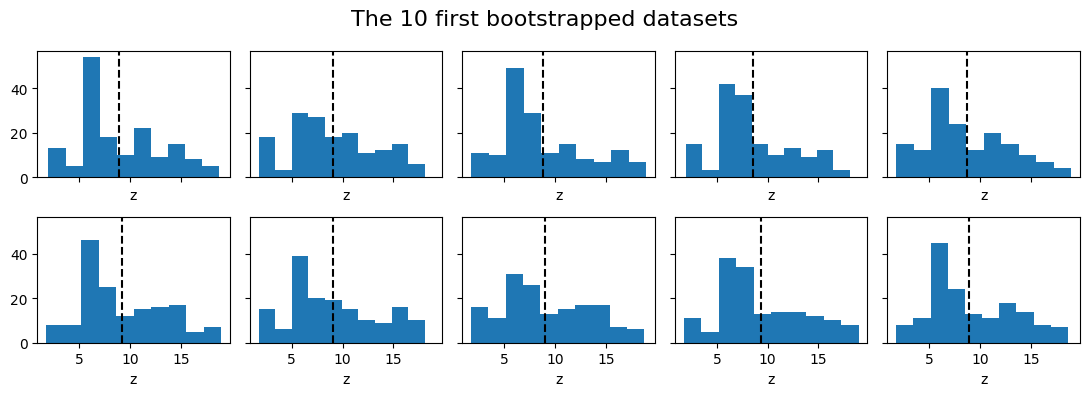

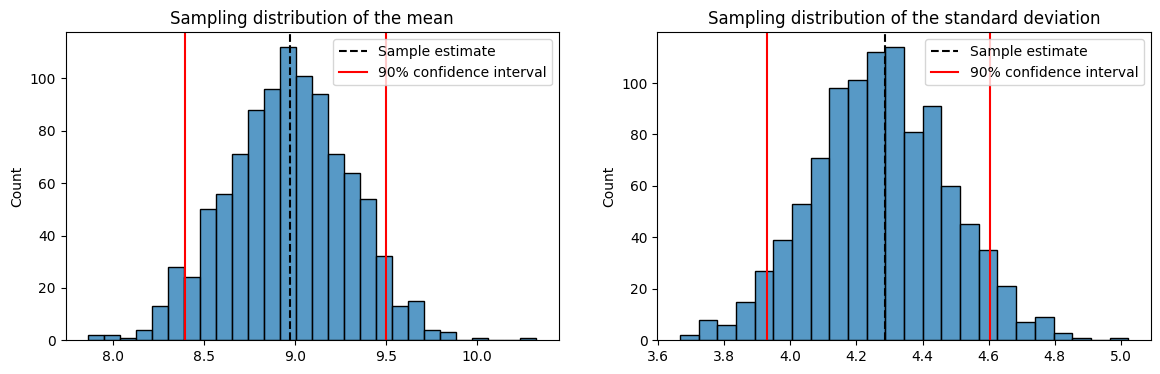

In [9]:
n_resamples = 1000

z = df['Height']

sample_mean = np.mean(z)
sample_std = np.std(z, ddof=1)

nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(11, 4))
axes = axes.flatten()

bootstrap_means = []
bootstrap_stds = []
for i in range(n_resamples):
    dataset = resample(z, n_samples=len(z), replace=True)
    bootstrap_mean = np.mean(dataset)
    bootstrap_std = np.std(dataset, ddof=1)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_stds.append(bootstrap_std)
    if i < nrows * ncols: # We plot an example of bootstrap dataset
        axis = axes[i]
        axis.hist(dataset)
        axis.axvline(bootstrap_mean, color='black', ls='--', label='Bootstrap mean')
        axis.set_xlabel('z')
fig.suptitle('The 10 first bootstrapped datasets', fontsize=16)
fig.tight_layout()


def plot_confidence_interval(sample_estimate, bootstrap_estimates, axis):
    interval = np.quantile(bootstrap_estimates, q=[0.05, 0.95])
    print(f'Sample estimate: {sample_estimate:.2f}')
    print(f'Confidence Interval: [{interval[0]:.2f}, {interval[1]:.2f}]')
    sns.histplot(data=bootstrap_estimates, ax=axis)
    axis.axvline(sample_estimate, color='black', ls='--', label='Sample estimate')
    axis.axvline(interval[0], color='red', label='90% confidence interval')
    axis.axvline(interval[1], color='red')
    axis.legend()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_confidence_interval(sample_mean, bootstrap_means, axes[0])
axes[0].set_title('Sampling distribution of the mean')
plot_confidence_interval(sample_std, bootstrap_stds, axes[1])
axes[1].set_title('Sampling distribution of the standard deviation');

**7) Similarly to cross-validation, the bootstrap can be used to estimate the validation error of any learning model. To this end, perform the following steps:**
- **Using the provided preprocessor, create a pipeline to apply the same preprocessing steps as in the previous lab followed by a linear regression model.** 
- **For $b=1,...,1000$:**
    - **Sample a training dataset $\mathcal{D}_{\text{train}}^{(b)}$ with replacement from the original dataset $\mathcal{D}$.**
    - **Define a test dataset $\mathcal{D}_{\text{test}}^{(b)}$ containing the observations from $\mathcal{D}$ that are not in $\mathcal{D}_{\text{train}}^{(b)}$.**
    - **For $\mathcal{D}_{\text{train}}^{(b)}$ and $\mathcal{D}_{\text{test}}^{(b)}$, select 'Height' as the target variable, and the remaining variables as predictors.**
    - **Fit the pipeline on $\mathcal{D}_{\text{train}}^{(b)}$.**
    - **Predict on $\mathcal{D}_{\text{test}}^{(b)}$.**
    - **Compute the $\text{MSE}^{(b)}$ on $\mathcal{D}_{\text{test}}^{(b)}$.**
    - **Put $\text{MSE}^{(b)}$ in a list.**

**With this procedure, we obtain the sampling distribution of the MSE.**
- **Plot this sampling distribution using a histogram.**
- **Add a point estimate $\text{MSE} = \frac{1}{B}\sum_{b=1}^B \text{MSE}^{(b)}$ on the plot.**
- **Add a 90% upper bound for the MSE on the plot, which corresponds to an interval from $-\infty$ to the quantile 0.9 of the sampling distribution.**

In [10]:
X, y = df.drop(columns='Height'), df[['Height']]

cont_columns = X.select_dtypes(include=['float64']).columns
cat_columns = X.select_dtypes(include=['category']).columns
# Transformers for imputation
cont_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_pipeline = make_pipeline(cat_imputer, OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

# ColumnTransformer to apply transformations to the correct features
preprocessor = ColumnTransformer(transformers=[
    ('cont', cont_imputer, cont_columns),
    ('cat', cat_pipeline, cat_columns)
])

Test MSE: 1.459287637629722


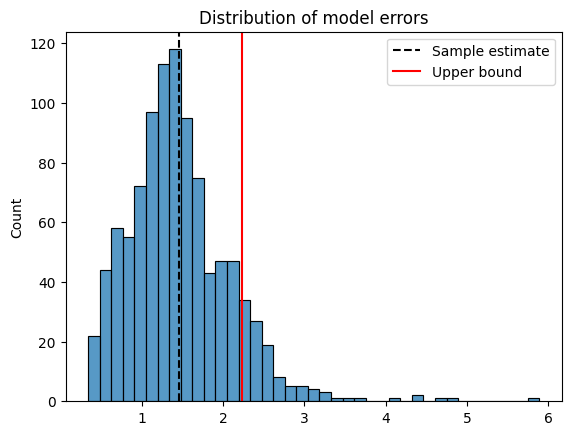

In [11]:
n_resamples = 1000

# Including the preprocessing in the pipeline allows to avoid data leakage.
model = make_pipeline(preprocessor, LinearRegression())
bootstrap_errors = []
for i in range(n_resamples):
    train_dataset = resample(df, n_samples=df.shape[0], replace=True)
    test_dataset = df[~df.index.isin(train_dataset.index)]
    X_train, y_train = train_dataset[X.columns], train_dataset['Height']
    X_test, y_test = test_dataset[X.columns], test_dataset['Height']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bootstrap_error = mean_squared_error(y_pred, y_test)
    bootstrap_errors.append(bootstrap_error)


test_mse = np.mean(bootstrap_errors)
print(f'Test MSE: {test_mse}')
upper_bound = np.quantile(bootstrap_errors, q=0.9)

fig, axis = plt.subplots()
sns.histplot(data=bootstrap_errors, ax=axis)
axis.axvline(test_mse, color='black', ls='--', label='Sample estimate')
axis.axvline(upper_bound, color='red', label='Upper bound')
axis.set_title('Distribution of model errors')
axis.legend();

**We can verify that we obtain a relatively similar test MSE with cross-validation.**

In [12]:
cv_results = cross_validate(model, X, y, cv=3, scoring=['neg_mean_squared_error'], return_estimator=True, return_indices=True)
test_mse_per_fold = -cv_results['test_neg_mean_squared_error']
print(f'Test MSE: {test_mse_per_fold.mean():.2f}')

Test MSE: 1.57
